### Online Machine Learning Experiments

Jay Urbain, PhD

#### Description

We conduct experiements in online machine learning where machine learning models incrementally learn and predict future values. In our approach, we retrain our models across all previous data with each new increment of samples. These samples can be of any granularity, i.e., 1 or more. Machine learning model coefficients are updated with each increment of data. 

We perform experiments for both classification (class target value) and regression (numeric target value) to test the feasibility of several machine learning algorithms for our incremental learning approach. Across 3 sets of data, we find our online machine learning approach to be very accurate.

**Datesets**
- digits - numeric prediction classification  
- boston house - regression for house value prediction  
- diabetes - regression and classification of self-monitored blood glucose (SMBG) data  

**Machine Learning Models**

The top performing classification model was a Support Vector Machine with test error < 2.5%.

The top performing regression models included ordinary least squares (OLS) and ridge regression using cross-validation (to identify the weigthing of a regularization term). Average mean-squared error (MSE) was < 2% for both the Boston house price prediction and SMBG prediction. 

The diabetes data set is our target data set, therefore we go into more depth in our explanation (below) and preprocessing.

#### Diabetes dataset
The diabetes dataset consists of 10 physiological variables (age, sex, weight, blood pressure) measure on 442 patients, and an indication of disease progression after one year:

Diabetes patient records were obtained from two sources:  an automatic
electronic recording device and paper records.  The automatic device
had an internal clock to timestamp events, whereas the paper records
only provided "logical time" slots (breakfast, lunch, dinner,
bedtime).  For paper records, fixed times were assigned to breakfast
(08:00), lunch (12:00), dinner (18:00), and bedtime (22:00).  Thus
paper records have fictitious uniform recording times whereas
electronic records have more realistic time stamps.

Diabetes files consist of four fields per record.  Each field is
separated by a tab and each record is separated by a newline.

File Names and format:

(1) Date in MM-DD-YYYY format

(2) Time in XX:YY format

(3) Code

(4) Value

The Code field is deciphered as follows:

33 = Regular insulin dose

34 = NPH insulin dose (intermediate acting)

35 = UltraLente insulin dose (long acting)

48 = Unspecified blood glucose measurement

57 = Unspecified blood glucose measurement

58 = Pre-breakfast blood glucose measurement

59 = Post-breakfast blood glucose measurement

60 = Pre-lunch blood glucose measurement

61 = Post-lunch blood glucose measurement

62 = Pre-supper blood glucose measurement

63 = Post-supper blood glucose measurement

64 = Pre-snack blood glucose measurement

65 = Hypoglycemic symptoms

66 = Typical meal ingestion

67 = More-than-usual meal ingestion

68 = Less-than-usual meal ingestion

69 = Typical exercise activity

70 = More-than-usual exercise activity

71 = Less-than-usual exercise activity

72 = Unspecified special event

In [1]:
# reset environment
%reset

import numpy as np
import pandas as pd
import glob
import re
import csv

# define insulin and glucose measurements
insulin_injections =[33,34,35]

glucose_measurements = [48,57,58,59,60,61,62,63,64]
'''
48 = Unspecified blood glucose measurement
57 = Unspecified blood glucose measurement
58 = Pre-breakfast blood glucose measurement
59 = Post-breakfast blood glucose measurement
60 = Pre-lunch blood glucose measurement
61 = Post-lunch blood glucose measurement
62 = Pre-supper blood glucose measurement
63 = Post-supper blood glucose measurement
64 = Pre-snack blood glucose measurement
'''
glucose_measurements_pre_meal  = [58,60,62,64]
glucose_measurements_post_meal = [59,61,63]
glucose_measurements_unspec    = [48,57]

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#### Sliding window functions

Assumes df rows are sorted most recent first in ascending order.

In [3]:
# Calculate a moving average on length n items in measurements
# Note: This is a sparse calculation since the calculations are
# carried forward over records that do not contain an item in measurements.
def sparse_moving_average(df, measurements, n=5):
    nlist = []
    mvalist = []
    #count = 0
    mva = 0.
    for index, row in df.iterrows():
        if row.code in measurements:
            nlist.append(row.value)
        if len(nlist) > n:
            nlist.pop(0)
        if len(nlist) > 0:
            mva = np.mean(nlist)
        #print 'code=', row.code, 'value=', row.value, 'mva=', mva, 'nlist=', nlist
        mvalist.append(mva)
    return mvalist
'''
ma_list = sparse_moving_average(diabetes_df, glucose_measurements, n=3)
print diabetes_df.shape
#print ma_list
print len(ma_list)
print ma_list[:20]
'''

# Same as sparse moving average, however calulate the median.
def sparse_moving_median(df, measurements, n=5):
    nlist = []
    medlist = []
    #count = 0
    med = 0.
    for index, row in df.iterrows():
        if row.code in measurements:
            nlist.append(row.value)
        if len(nlist) > n:
            nlist.pop(0)
        if len(nlist) > 0:
            med = np.median(nlist)
        #print 'code=', row.code, 'value=', row.value, 'med=', med, 'nlist=', nlist
        medlist.append(med)
        #count += 1
        #if count == 10: 
        #    break
    return medlist
'''
mm_list = sparse_moving_median(diabetes_df, glucose_measurements, n=3)
print diabetes_df.shape
#print ma_list
print len(mm_list)
print mm_list[:20]
'''

# Calculate the percentage of records of the past n records that contain an item in measurements.
def sparse_moving_percent(df, measurements, n=5):
    percent_list = []
    count = 0
    total_count = 0
    for index, row in df.iterrows():
        if row.code in measurements:
            count += 1
        total_count += 1
        percent = float(count)/total_count
        percent_list.append( percent )
        #print 'code=', row.code, 'value=', row.value, 'percent=', percent
        #if total_count == 5: 
        #    break
    return percent_list
'''
p_list = sparse_moving_percent(diabetes_df, glucose_measurements, n=10)
print len(p_list)
print p_list[:20]
print diabetes_df.head(20)
'''

# Calculate the running count of items in measurements over the past n records.
# A negative value for n will result in counting all records.
def sparse_moving_count(df, measurements, n=20):
    nlist = []
    medlist = []
    for index, row in df.iterrows():
        if row.code in measurements:
            nlist.append(1)
        else:
            nlist.append(0)
        if n > 0 and len(nlist) > n:
            nlist.pop(0)
        medlist.append(np.sum(nlist))
    return medlist


#### Preprocessing

In [5]:
def preprocessDf(df, id) :
    
    # add id column
    df.insert(0, 'id', id[0])
    
    # add date_, time_, datetime_ columns of datetime type
    #diabetes_df['date_'] = pd.to_datetime(df.date, format='%m-%d-%Y', errors='coerce')
    #diabetes_df['time_'] = pd.to_datetime(df.time, format='%M:%H', errors='coerce')
    diabetes_df['datetime_'] = pd.to_datetime(df.date + ' ' + df.time, errors='coerce')
    
    # convert value to numeric
    df['code'] = pd.to_numeric(df['code'], errors='coerce')
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    
    # generate stats 
    # all glucose measurements
    m_list = sparse_moving_average(df, glucose_measurements, n=1)
    df['glu_avg_all_1'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements, n=3)
    df['glu_avg_all_3'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements, n=5)
    df['glu_avg_all_5'] = m_list
    
    m_list = sparse_moving_median(df, glucose_measurements, n=1)
    df['glu_med_all_1'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements, n=3)
    df['glu_med_all_3'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements, n=5)
    df['glu_med_all_5'] = m_list
    
    # glucose_measurements_pre_meal  = [58,60,62,64]
    m_list = sparse_moving_average(df, glucose_measurements_pre_meal, n=1)
    df['glu_pre_avg_all_1'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements_pre_meal, n=3)
    df['glu_pre_avg_all_3'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements_pre_meal, n=5)
    df['glu_pre_avg_all_5'] = m_list
    
    m_list = sparse_moving_median(df, glucose_measurements_pre_meal, n=1)
    df['glu_pre_med_all_1'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements_pre_meal, n=3)
    df['glu_pre_med_all_3'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements_pre_meal, n=5)
    df['glu_pre_med_all_5'] = m_list
    
    # glucose_measurements_post_meal = [59,61,63]
    m_list = sparse_moving_average(df, glucose_measurements_post_meal, n=1)
    df['glu_post_avg_all_1'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements_post_meal, n=3)
    df['glu_post_avg_all_3'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements_post_meal, n=5)
    df['glu_post_avg_all_5'] = m_list
    
    m_list = sparse_moving_median(df, glucose_measurements_post_meal, n=1)
    df['glu_post_med_all_1'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements_post_meal, n=3)
    df['glu_post_med_all_3'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements_post_meal, n=5)
    df['glu_post_med_all_5'] = m_list
    
    # glucose_measurements_unspec    = [48,57]
    m_list = sparse_moving_average(df, glucose_measurements_unspec, n=1)
    df['glu_unspec_avg_all_1'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements_unspec, n=3)
    df['glu_unspec_avg_all_3'] = m_list
    m_list = sparse_moving_average(df, glucose_measurements_unspec, n=5)
    df['glu_unspec_avg_all_5'] = m_list
    
    m_list = sparse_moving_median(df, glucose_measurements_unspec, n=1)
    df['glu_unspec_med_all_1'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements_unspec, n=3)
    df['glu_unspec_med_all_3'] = m_list
    m_list = sparse_moving_median(df, glucose_measurements_unspec, n=5)
    df['glu_unspec_med_all_5'] = m_list
      
    # percents and counts
    m_list = sparse_moving_percent(df, glucose_measurements, n=20)
    df['glu_pct_all'] = m_list
    m_list = sparse_moving_percent(df, insulin_injections, n=20)
    df['ins_pct_all'] = m_list 
    
    #df_list = sparse_moving_count(diabetes_df, glucose_measurements, -1)
    m_list = sparse_moving_count(df, glucose_measurements, 20)
    df['glu_cnt_all'] = m_list
    m_list = sparse_moving_count(df, insulin_injections, 20)
    df['ins_cnt_all'] = m_list 
    
    return df


#### Diabetes Data Import

In [6]:
path ='/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data'
allFiles = glob.glob(path + "/*data*")
diabetes_df = pd.DataFrame()
count = 0
for file_ in allFiles:
    print file_
    id = re.findall('\d+', file_ )
    df = pd.read_table(file_,index_col=None, header=None, names=['date','time','code','value'])
    df = preprocessDf(df, id)
        
    #print np.isfinite(df['code']).all()
    
    #print df.shape
    #print df.head()
    #print df.tail()
    if count == 0:
        diabetes_df = df
        count += 1
    else:
        diabetes_df.append(df, ignore_index=True)
    #break
    
print diabetes_df.shape
print diabetes_df.head()
print diabetes_df.tail()

/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-01
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-02


/Applications/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3558: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-03
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-04
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-05
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-06
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-07
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-08
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-09
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-10
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-11
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-12
/Users/jayurbain/Dropbox/machine-learning/machine-learning/data/Diabetes-Data/data-13
/Users/jayurbain/Dropbox/machine-learning/machine-lear

#### Evaluation of Stochastic Gradient Descent (SGD) on random data across multiple classifiers

Each classifier is evaluated across descreasing levels of hold out data, i.e., 95% (trained on 5%), 90% (trained on 10%), etc.

#### Classifier and Regressor Models

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
# plots within notebook versus launching a separate window
%matplotlib inline 

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.svm import SVC
from sklearn.svm import SVR
import math
from sklearn import datasets

heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20
digits = datasets.load_digits()
    
classifiers = [
    ("SGD", SGDClassifier()),
    ("ASGD", SGDClassifier(average=True)),
    ("Perceptron", Perceptron()),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge', C=1.0)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',C=1.0)),
    #("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / X.shape[0]))
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.0)),
    #("SVMlinear", SVC(C=1.0, kernel='linear'))
    ("SVClinear", SVC(C=1.0, kernel='linear', probability=True))
]

regressors = [
    ("OLS", LinearRegression(normalize=False)),
    #("OLSN", LinearRegression(normalize=True)),
    #("Ridge", Ridge(alpha = .5)),
    ("RidgeCV", RidgeCV(alphas=[0.01, 0.1, 0.5, 1.0, 5.0, 10.0])),
    #("Lasso", Lasso(alpha = .5)),
    ("LassoCV", LassoCV(alphas=[0.01, 0.1, 0.5, 1.0, 5.0, 10.0]))
    #("svr_rbf", SVR(kernel='rbf', C=1.0, epsilon=0.2))
    #("svr_lin", SVR(kernel='linear', C=1.0, epsilon=0.2))
    #("svr_poly", SVR(kernel='poly', C=1e3, degree=2))
    ]


#### SGD classification on digits data set

training SGD
training ASGD
training Perceptron
training Passive-Aggressive I
training Passive-Aggressive II
training SAG
training SVClinear
[[ 0.06597682  0.06484287  0.02970624  0.00937077  0.04292513  0.01796168
   0.59524153  0.03220318  0.06286363  0.07890815]]
[[ 0.01134321  0.01938766  0.04981672  0.0557206   0.02228304  0.71767328
   0.00868589  0.03984726  0.03262671  0.04261564]]
[[ 0.02897615  0.0471157   0.0234206   0.0548802   0.04153014  0.0636718
   0.02239152  0.10931314  0.12104515  0.48765561]]
[[ 0.056098    0.07497965  0.05624073  0.03107984  0.0812321   0.42480024
   0.05847773  0.10321342  0.06480922  0.04906907]]
[[ 0.01875033  0.12911396  0.04926696  0.05358509  0.02692863  0.02021886
   0.05583559  0.04724597  0.55121018  0.04784443]]
[[ 0.01833311  0.08096469  0.06089786  0.09217785  0.03267945  0.03631916
   0.0183176   0.55493183  0.06513051  0.04024794]]
[[ 0.02184108  0.08411375  0.03376951  0.61374611  0.00953523  0.07022507
   0.01366531  0.01994855  0.03

/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.01421175  0.19904251  0.03485168  0.04403729  0.06754748  0.01743155
   0.53349823  0.01408678  0.05946944  0.01582329]]
[[ 0.00518621  0.71015891  0.01922399  0.01125971  0.07348461  0.02762802
   0.06676252  0.01662441  0.04548252  0.02418909]]
[[ 0.02320925  0.03177449  0.02889751  0.07786296  0.08618203  0.02093232
   0.01473114  0.58003565  0.03695218  0.09942247]]
[[ 0.02072117  0.01808296  0.03326912  0.56757303  0.01538853  0.02544102
   0.00994421  0.02203905  0.02352495  0.26401597]]
[[ 0.01595435  0.50519112  0.02253623  0.04008563  0.13389469  0.03911529
   0.01344513  0.05608357  0.05492749  0.11876649]]
[[ 0.52066596  0.02226481  0.05276587  0.04178998  0.03120778  0.05375384
   0.05806204  0.06792367  0.08565357  0.06591247]]
[[ 0.11873312  0.07247065  0.09453217  0.01960273  0.07181255  0.03167933
   0.51504745  0.01549512  0.03730271  0.02332416]]
[[ 0.0137352   0.22000408  0.24993351  0.1154887   0.03203747  0.09582855
   0.05620017  0.01669411  0.05850384  0.141

/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.01107438  0.03084237  0.69301281  0.14136185  0.0190952   0.02441015
   0.01674606  0.01987839  0.02983971  0.01373909]]
[[ 0.00785605  0.01503202  0.00641568  0.05969872  0.00622194  0.81590485
   0.01827142  0.01469117  0.02683265  0.0290755 ]]
[[ 0.09032074  0.02431256  0.02528779  0.08497356  0.01158112  0.09194181
   0.00792425  0.0226405   0.1035976   0.53742006]]
[[ 0.0300615   0.0129167   0.01209364  0.00770529  0.014313    0.0281199
   0.85856611  0.00676336  0.02465157  0.00480894]]
[[ 0.01280209  0.00406262  0.051933    0.81652988  0.00161416  0.01091762
   0.00323714  0.0099767   0.01076055  0.07816625]]
[[ 0.03327083  0.33633624  0.06951903  0.02659715  0.07221435  0.04891004
   0.16499817  0.01731851  0.21426035  0.01657533]]
[[ 0.00254205  0.85168237  0.01131134  0.00593436  0.00965851  0.00214088
   0.01137726  0.01248679  0.08595493  0.00691151]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.03991951  0.03605328  0.01006347  0.00787639  0.13962454  0.01891289
   0.71263813  0.01038483  0.01716445  0.0073625 ]]
[[ 0.00383311  0.72619269  0.03006428  0.05132363  0.01629823  0.00611977
   0.00606336  0.02506419  0.12050826  0.01453247]]
[[ 0.10363783  0.06535943  0.08042166  0.01642488  0.1058432   0.03521839
   0.47097666  0.02064067  0.08602266  0.01545462]]
[[ 0.01309172  0.03030811  0.67368707  0.10474205  0.00796611  0.02493551
   0.02348105  0.03929123  0.06332404  0.01917312]]
[[ 0.00326404  0.00734683  0.03781611  0.84753291  0.00327285  0.01016549
   0.00159328  0.01340445  0.06242092  0.01318312]]
[[ 0.78783418  0.00651396  0.03562691  0.01553051  0.01516976  0.03013754
   0.01691505  0.01470949  0.03005374  0.04750885]]
[[ 0.03358575  0.13880088  0.00624914  0.01031814  0.62934353  0.012556
   0.07423564  0.03364689  0.03127981  0.02998424]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.63202257  0.02330987  0.04703017  0.0342413   0.0167053   0.08484577
   0.05382242  0.01469857  0.04037468  0.05294934]]
[[ 0.0088992   0.00774836  0.69510295  0.201844    0.00435286  0.01095617
   0.00941303  0.01345496  0.02060042  0.02762806]]
[[ 0.03673831  0.01988015  0.05899503  0.14757482  0.01374775  0.06323808
   0.02493761  0.04862399  0.06293209  0.52333216]]
[[ 0.00968904  0.20555068  0.1666182   0.12507693  0.01870768  0.08064554
   0.00847306  0.09470293  0.2355443   0.05499166]]
[[ 0.00380923  0.00813245  0.0059951   0.95234861  0.00180183  0.00722188
   0.00407383  0.00394862  0.00316888  0.00949957]]
[[ 0.03389534  0.01990874  0.01557849  0.00740652  0.76360234  0.00671829
   0.01643409  0.09894402  0.02797413  0.00953803]]
[[ 0.77896413  0.01102613  0.05755663  0.01427471  0.01171723  0.0175175
   0.03477195  0.007293    0.02693862  0.0399401 ]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[  6.87849998e-03   5.44822973e-03   1.27078670e-03   2.25633827e-03
    9.57394624e-01   1.38445357e-03   5.69325109e-03   1.49079126e-02
    3.89131255e-03   8.74591199e-04]]
[[  3.66961320e-04   8.50265801e-01   3.07942143e-03   1.11435698e-02
    8.66667215e-02   8.14124736e-04   1.22386830e-03   8.00618731e-03
    2.87274187e-02   9.70592563e-03]]
[[ 0.01719344  0.00479133  0.00608619  0.00560952  0.02829948  0.00927017
   0.90326541  0.00545016  0.01646871  0.00356559]]
[[ 0.00442249  0.03830475  0.00470912  0.03449899  0.0751161   0.05823139
   0.0062061   0.06788797  0.44244004  0.26818305]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.00295703  0.00750947  0.03805913  0.0054386   0.01116239  0.00769055
   0.00455759  0.0109258   0.90187357  0.00982587]]
[[ 0.85095592  0.02549861  0.01487468  0.0075924   0.00803609  0.00682135
   0.0244176   0.00225005  0.02306561  0.03648769]]
[[ 0.030867    0.02037423  0.05935578  0.08223033  0.00772315  0.01568013
   0.01092413  0.00955854  0.03371554  0.72957118]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.01617459  0.0640738   0.01025961  0.01528271  0.24388847  0.03250457
   0.01761475  0.36160728  0.041822    0.19677222]]
[[ 0.00460743  0.005147    0.00632848  0.00405536  0.0064929   0.01136727
   0.92783696  0.00550442  0.02345745  0.00520273]]
[[ 0.00255965  0.01926866  0.00341108  0.00518401  0.93083305  0.00514585
   0.00530251  0.01975654  0.00583601  0.00270265]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.00431135  0.05307574  0.08380233  0.01026677  0.01688833  0.010074
   0.77032613  0.00552917  0.03715774  0.00856844]]
[[ 0.00349295  0.01095048  0.03111601  0.03264633  0.008236    0.02283212
   0.00284437  0.80978986  0.01685733  0.06123456]]
[[ 0.00316789  0.00969782  0.00175686  0.00515864  0.0026278   0.00517416
   0.96139782  0.00180053  0.00614849  0.00306999]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.00385823  0.00497452  0.00204116  0.01709757  0.00655875  0.93757408
   0.00192912  0.00774872  0.00583365  0.0123842 ]]
[[ 0.91341342  0.0030855   0.00489302  0.01048748  0.00421234  0.01689973
   0.02247055  0.00587916  0.00906896  0.00958983]]
[[  3.28012004e-04   9.59807645e-01   1.50050756e-03   2.11624770e-03
    5.09605149e-03   1.48199581e-03   8.61217388e-04   1.14403917e-03
    2.07308022e-02   6.93348150e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.01143888  0.00645391  0.07879049  0.80489899  0.00377137  0.01868869
   0.00506467  0.01526834  0.01527831  0.04034635]]
[[  7.97400226e-04   9.65427677e-01   9.79378371e-04   3.92138334e-03
    9.33305669e-03   4.81748179e-03   4.38406580e-04   1.49351423e-03
    5.01246451e-03   7.77923762e-03]]
[[ 0.00400584  0.0106295   0.00214576  0.0043518   0.91255634  0.03385417
   0.01718096  0.00723995  0.00709645  0.00093924]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

[[ 0.00743438  0.00416401  0.01892478  0.01256845  0.01395011  0.01411626
   0.89853105  0.00784539  0.01566361  0.00680196]]
[[ 0.00418311  0.02187597  0.00667424  0.0293733   0.10536431  0.00980656
   0.00770823  0.77520576  0.02317481  0.0166337 ]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.80689848  0.00335341  0.01149665  0.01515494  0.00844341  0.04236274
   0.07932167  0.00950948  0.01354974  0.00990949]]
[[  3.06361325e-04   2.23009837e-03   1.91132247e-03   2.16964257e-03
    2.34760971e-04   9.77896693e-01   2.69502787e-04   2.45226875e-03
    5.98686495e-03   6.54248524e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  7.07147699e-04   9.39433887e-01   2.31997026e-02   2.72211127e-03
    6.35388429e-03   2.72453642e-04   3.15309707e-03   4.55555600e-03
    1.88547583e-02   7.47402212e-04]]
[[ 0.00189659  0.00127578  0.00181096  0.00222225  0.00406128  0.0186968
   0.00227607  0.95283827  0.01222393  0.00269806]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  1.14676156e-03   1.66087260e-02   4.61973972e-03   9.02221081e-03
    1.47026267e-03   9.95550319e-04   5.75590570e-02   8.94795392e-04
    9.04549888e-01   3.13300886e-03]]
[[ 0.10867028  0.14316853  0.01084716  0.00949162  0.22598004  0.04204828
   0.39053006  0.01355823  0.02336305  0.03234274]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.8491302   0.02056382  0.00286999  0.00742208  0.0078078   0.03918488
   0.01434986  0.00401602  0.02243444  0.03222091]]
[[  2.38108581e-03   4.58182142e-04   6.44277396e-04   1.28120820e-04
    9.89674848e-01   6.70818275e-04   3.81177622e-03   9.50731710e-04
    1.22880503e-03   5.13547552e-05]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.00558002  0.00177023  0.00547113  0.01682429  0.00214455  0.00366007
   0.00350124  0.02086839  0.0056168   0.93456329]]
[[ 0.00212305  0.86768011  0.0019986   0.00675104  0.07197316  0.00210321
   0.00687706  0.00706493  0.02221432  0.01121452]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  2.04212270e-03   8.22452822e-04   3.68397149e-03   9.64237677e-01
    3.11828099e-03   8.25625454e-03   3.70664206e-04   9.92592543e-03
    4.72885382e-03   2.81379738e-03]]
[[ 0.97295392  0.00279405  0.00131263  0.00204174  0.00151029  0.00717901
   0.00404408  0.00190032  0.00357943  0.00268453]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.01778987  0.00694282  0.00713424  0.01104708  0.00637527  0.03370691
   0.86680581  0.00300415  0.04269736  0.00449649]]
[[  2.27741777e-03   1.21984894e-03   3.40390059e-03   6.83158542e-03
    2.15178862e-03   8.97780355e-04   4.68337604e-04   9.79781758e-01
    1.75535840e-03   1.21222387e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  2.76128432e-05   1.09051812e-04   2.49989131e-04   7.95342467e-03
    1.12890178e-04   9.89994816e-01   6.11404705e-05   1.15149530e-04
    1.16206126e-03   2.13863868e-04]]
[[ 0.96811478  0.00099262  0.00135376  0.0028287   0.0014074   0.00655364
   0.00233347  0.00332387  0.00697939  0.00611237]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  1.26214757e-04   3.35204227e-04   9.88035269e-01   3.77227482e-03
    1.52418876e-04   2.82538937e-04   1.82171745e-04   2.82174425e-03
    1.99224111e-03   2.29992216e-03]]
[[ 0.00402713  0.65042998  0.01059347  0.00195572  0.0088551   0.00119624
   0.0226519   0.00192433  0.29587575  0.0024904 ]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  6.76744381e-04   1.83519110e-03   3.29169172e-03   2.18481487e-02
    2.22447064e-03   7.17135446e-03   7.28383700e-04   3.33447127e-03
    8.90977082e-01   6.79124620e-02]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.94803489  0.00171577  0.00237323  0.00518051  0.00236045  0.00942841
   0.00560567  0.00528768  0.00796962  0.01204377]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  3.11513451e-03   7.02850248e-04   2.36029790e-04   2.05188117e-03
    1.11635302e-03   9.82645896e-01   2.08004567e-03   4.69774147e-03
    2.04302302e-03   1.31104524e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  1.53124324e-03   1.00179619e-03   1.43572869e-04   1.29479981e-02
    5.55583238e-03   9.51585951e-01   4.61691750e-03   3.36835497e-03
    1.37436522e-02   5.50468103e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.00411094  0.04744429  0.00358047  0.07232558  0.02617492  0.74301552
   0.02109505  0.00729462  0.0613528   0.01360582]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  2.48689089e-03   9.96655172e-03   9.70189519e-01   7.98888085e-04
    2.13193334e-03   1.88452491e-04   5.09428569e-03   1.69942326e-03
    6.23713601e-03   1.20691990e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  4.48696908e-07   1.31628822e-06   9.99173743e-01   1.06803376e-04
    4.89237777e-05   2.33340925e-04   2.19945688e-04   3.52599410e-05
    3.67025382e-05   1.43515307e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  2.17911760e-03   3.88354539e-04   7.85212851e-04   5.86354613e-03
    2.36181513e-04   9.83768442e-01   1.49811222e-03   2.47302721e-04
    3.68013471e-03   1.35359540e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  1.46960550e-03   6.28784684e-04   2.40336420e-03   9.76494104e-01
    1.16956561e-03   6.93376713e-03   1.08156356e-03   1.19186193e-03
    5.02649122e-03   3.60089201e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  8.04511349e-04   8.73724529e-03   1.83623170e-04   2.49629733e-03
    6.57564456e-04   1.14663316e-03   9.80027797e-01   2.56228188e-04
    3.82603236e-03   1.86406720e-03]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  5.32407816e-04   1.89189275e-03   3.17875455e-04   1.29369760e-03
    1.84311719e-03   4.75724125e-03   9.75958691e-01   5.08364809e-04
    1.25348747e-02   3.61837382e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  4.19923915e-03   9.73958180e-01   9.69867340e-04   1.38900176e-03
    6.08109480e-04   8.77613325e-04   1.25538698e-02   2.64824278e-04
    4.54869712e-03   6.30597313e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  1.03988358e-06   3.82620055e-06   9.98085059e-01   1.08750314e-04
    9.97471839e-05   1.86877586e-04   2.50651765e-04   3.52589370e-04
    6.37923957e-04   2.73534507e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  9.30667825e-04   1.12109771e-03   1.01594393e-03   3.86867056e-03
    2.34586794e-03   9.59104891e-01   1.56724093e-03   7.90511775e-04
    7.95828796e-04   2.84592796e-02]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  9.89596499e-01   1.73725572e-04   4.03638649e-03   1.35930481e-03
    2.40213309e-04   1.53357695e-03   1.08590772e-03   3.59308551e-04
    9.30964535e-04   6.84112917e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.00102117  0.00266011  0.00292079  0.005764    0.00192848  0.00127547
   0.00107522  0.93388593  0.04630426  0.00316456]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[ 0.00227871  0.00188134  0.00108043  0.01200524  0.00597518  0.01653061
   0.0051151   0.00791295  0.9369658   0.01025464]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  3.40751999e-04   9.65430522e-04   3.04155296e-04   2.23713389e-03
    9.62019244e-04   7.13722898e-03   5.88945498e-04   9.63354485e-01
    3.41616238e-03   2.06936869e-02]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  2.91648488e-04   1.73539061e-04   9.95413472e-01   6.04262519e-04
    6.41384969e-04   4.06727021e-04   1.60711881e-04   1.35544545e-03
    5.68487070e-04   3.84321282e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[  1.53213094e-03   3.12025786e-03   9.89674155e-05   5.55023483e-03
    2.52992397e-03   9.60128481e-01   4.93605324e-04   4.62880720e-03
    8.53336379e-03   1.33842272e-02]]
[[  1.37100494e-04   1.43323700e-05   3.91933411e-04   9.98020188e-01
    4.69653229e-05   3.16934277e-04   5.83260978e-06   4.00100134e-04
    2.96141075e-05   6.36998844e-04]]


/Applications/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


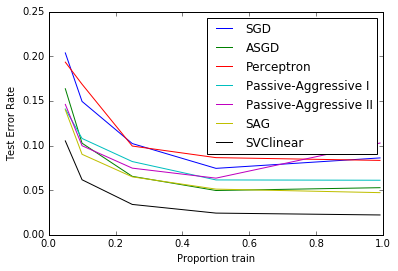

In [8]:
X, y = digits.data, digits.target

xx = 1. - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
            if name == "SVClinear":
                print clf.predict_proba(X_test[0])
        yy.append(np.mean(yy_))

    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()


In [19]:
print sum([1,2,3])

print sum([.06657449,  0.06911963,  0.02892965,  0.00858564,  0.04956085,  0.01983755, 0.57699796,  0.03700886,  0.0582358, 0.08514958])

6
1.00000001


### SGD regression on Boston housing dataset on *price*

Dataset:  <class 'sklearn.datasets.base.Bunch'>
Data:  <type 'numpy.ndarray'>
(379, 14) (127, 14) (379,) (127,)
Table 1. Multivariate coefficients
   Features  Coefficient Estimate
0      CRIM          1.665335e-16
1        ZN         -1.266348e-16
2     INDUS          1.457168e-16
3      CHAS         -6.905500e-15
4       NOX         -1.961972e-15
5        RM         -2.151057e-16
6       AGE         -3.209238e-17
7       DIS         -7.632783e-17
8       RAD         -2.775558e-16
9       TAX         -2.081668e-17
10  PTRATIO          3.053113e-16
11        B          1.986258e-16
12    LSTAT         -2.775558e-16
13    Price          1.000000e+00
Baseline batch regression:
Fit a model X_train, and calculate MSE with Y_train: 0.00
Fit a model X_train, and calculate MSE with X_test and Y_test: 0.00
training OLS
training RidgeCV
training LassoCV


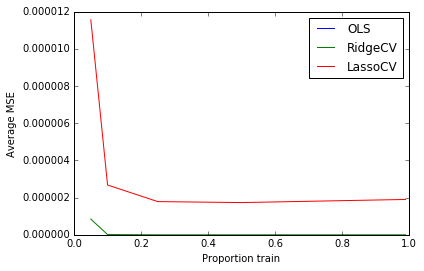

In [17]:
from sklearn.datasets import load_boston

boston = load_boston()
print 'Dataset: ', type(boston)
# the actual data is in a numpy array
print 'Data: ', type(boston.data)

# load the data into a pandas DataFrame
boston_df = pd.DataFrame(boston.data)

# add label columns to the dataframe from the original dataset
boston_df.columns = boston.feature_names

#show
boston_df.head()

#X_multi = boston_df[['RM', 'CHAS', 'NOX', 'DIS', 'PTRATIO', 'LSTAT', 'RAD', 'INDUS']]
X_multi = boston_df

# Targets
Y_target = boston.target

XX = boston_df
XX['Price'] = boston.target
from pandas.tools.plotting import scatter_matrix
#matplotlib.style.use('ggplot')
#scatter_matrix(XX, alpha=0.2, figsize=(6, 6), diagonal='kde')

# Regression object
lreg = LinearRegression()

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X_multi, Y_target)

# Print shapes of the training and testing data sets
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Build a linear regression on the training data only
lreg.fit(X_train, y_train)

# Create a DataFrame from the Features
def printCoefficients(df, lm):
    coeff_df = pd.DataFrame(df.columns)
    coeff_df.columns = ['Features']
    # Add a new column with the coefficients from the linear regression
    coeff_df["Coefficient Estimate"] = pd.Series(lm.coef_)
    # Show
    print 'Table 1. Multivariate coefficients'
    print coeff_df

printCoefficients(boston_df, lreg)

# Predictions on training and testing sets
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)
print "Baseline batch regression:"
print "Fit a model X_train, and calculate MSE with Y_train: %.2f"  % np.mean((y_train - pred_train) ** 2)  
print "Fit a model X_train, and calculate MSE with X_test and Y_test: %.2f"  % np.mean((y_test - pred_test) ** 2)

rng = np.random.RandomState(42)
yy = []

for name, lreg in regressors:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(X_multi, Y_target, test_size=i, random_state=rng)
            lreg.fit(X_train, y_train)
            y_pred = lreg.predict(X_test)
            mse = np.mean((y_test - y_pred) ** 2)
            rmse = np.sqrt( np.mean((y_test - y_pred) ** 2) )
            yy_.append(mse)
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Average MSE")
plt.show()


### Diabetes dataset regression online learning

   glu_avg_all_3  glu_avg_all_5  glu_med_all_3  glu_med_all_5  glu_pct_all  \
0          100.0          100.0          100.0          100.0     1.000000   
1          100.0          100.0          100.0          100.0     0.500000   
2          100.0          100.0          100.0          100.0     0.333333   
3          109.5          109.5          109.5          109.5     0.500000   
4          109.5          109.5          109.5          109.5     0.400000   

   ins_pct_all  
0     0.000000  
1     0.500000  
2     0.666667  
3     0.500000  
4     0.600000  
0    100
1    100
2    100
3    119
4    119
Name: glu_avg_all_1, dtype: float64
(707, 6) (236, 6) (707,) (236,)
Fit a model X_train, and calculate MSE with Y_train: 3060.40
Fit a model X_train, and calculate MSE with X_test and Y_test: 3108.37
training OLS
training RidgeCV
training LassoCV


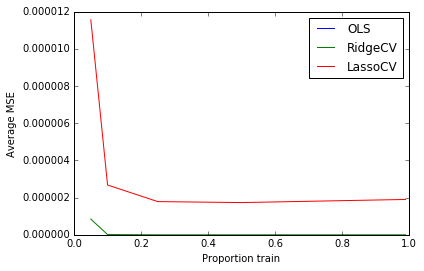

In [27]:

#X, y = diabetes_df[['glu_avg_all_3','glu_avg_all_5', 'ins_pct_all']], diabetes_df['glu_avg_all_1']

X, y = diabetes_df[['glu_avg_all_3','glu_avg_all_5', 'glu_med_all_3', 'glu_med_all_5', 'glu_pct_all', 'ins_pct_all']], diabetes_df['glu_avg_all_1']

print X.head()
print y.head()

# Regression object
lreg = LinearRegression()

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y)

# Print shapes of the training and testing data sets
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Build a linear regression on the training data only
lreg.fit(X_train, y_train)

# Perform baseline prediction on training and testing sets
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)
print "Fit a model X_train, and calculate MSE with Y_train: %.2f"  % np.mean((y_train - pred_train) ** 2)  
print "Fit a model X_train, and calculate MSE with X_test and Y_test: %.2f"  % np.mean((y_test - pred_test) ** 2)

rng = np.random.RandomState(42)
yy = []

for name, lreg in regressors:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(X_multi, Y_target, test_size=i, random_state=rng)
            lreg.fit(X_train, y_train)
            y_pred = lreg.predict(X_test)
            mse = np.mean((y_test - y_pred) ** 2)
            rmse = np.sqrt( np.mean((y_test - y_pred) ** 2) )
            yy_.append(mse)
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Average MSE")
plt.show()

In [ ]:
dates = pd.date_range('1/1/2000', periods=8)

df = pd.DataFrame(np.random.randn(8, 4), index=dates, columns=['A', 'B', 'C', 'D'])

print df

"""
#Using DataFrame.drop
    df.drop(df.columns[[1, 2]], axis=1, inplace=True)

    # drop by Name
    df1 = df1.drop(['B', 'C'], axis=1)


    ## Select the ones you want
    df1 = df[['a','d']]
"""
df2 = df.drop(['B'], axis=1)
print df2

X, y = diabetes_df.drop(['glu_avg_all_1'], axis=1), diabetes_df['glu_avg_all_1']
#print X.head()


X, y = diabetes_df[['glu_avg_all_3','glu_avg_all_5', 'ins_pct_all']], diabetes_df['glu_avg_all_1']


#### Work

### SVR test - Support Vector Machine Regression

Did not work well on Boston data set. So we need to experiment. Looks like we used it correctly.

In [20]:
from sklearn.svm import SVR
import numpy as np
n_samples, n_features = 10, 5
np.random.seed(0)
y = np.random.randn(n_samples)
X = np.random.randn(n_samples, n_features)
clf = SVR(C=1.0, epsilon=0.2)
clf.fit(X, y)
p = clf.predict(X)
print y
print p
#SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto',
#    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]
[ 0.89267763  0.60015715  0.98206621  1.85535147  0.92760639  0.37993472
  1.02794306  0.0486428   0.32927924  0.34111871]


In [ ]:

# Load the Pima Indians diabetes dataset from CSV URL
import numpy as np
import urllib
# URL for the Pima Indians Diabetes dataset (UCI Machine Learning Repository)
url = "http://goo.gl/j0Rvxq"
# download the file
raw_data = urllib.urlopen(url)
# load the CSV file as a numpy matrix
dataset = np.loadtxt(raw_data, delimiter=",")
print(dataset.shape)
# separate the data from the target attributes
X = dataset[:,0:7]
y = dataset[:,8]

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
digits = datasets.load_digits()
print(digits.data) 
print digits.target

In [ ]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(digits.data[:-1], digits.target[:-1]) 

In [ ]:
clf.fit(digits.data[:-1], digits.target[:-1]) 

In [ ]:
prediction = clf.predict(digits.data[-1:])
print prediction[0]

In [ ]:
from sklearn import datasets

import matplotlib.pyplot as plt

#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
#plt.imshow(prediction, cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()
print digits.images[-1]
print prediction

In [ ]:
# model persistance

from sklearn import svm
from sklearn import datasets
clf = svm.SVC()
iris = datasets.load_iris()
X, y = iris.data, iris.target
print clf.fit(X, y)  
clf2.predict(X[0:1])

In [ ]:
import pickle
s = pickle.dumps(clf)
clf2 = pickle.loads(s)
clf2.predict(X[0:1])

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'filename.pkl')
clf3 = joblib.load('filename.pkl')
clf3.predict(X[0:1])